#### Install required libraries

In [1]:
#! pip install zoish --force-reinstall
#! pip install  scikit-learn numpy lightgbm==4.0.0  nest-asyncio==1.5.7 plotly==5.16.1 pandas xgboost lohrasb ray xgboost feature-engine hyperopt ipywidgets  argcomplete==3.1.1 catboost==1.2.1 --force-reinstall


#### Imports


In [2]:
# Built-in libraries
import logging
import sys  # Added sys for version logging

# Third-party libraries for data manipulation and computation
import pandas as pd
import numpy  # Added numpy for version logging

# Scikit-learn libraries for modeling, metrics, and data transformation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import sklearn  

# XGBoost for machine learning modeling
import xgboost  # Added for version logging
from xgboost import XGBRegressor

# Feature Engine for imputation
from feature_engine.imputation import MeanMedianImputer

# Custom libraries for feature selection
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector, ShapPlotFeatures
import zoish  # Added for version logging

# Ray for distributed computing and hyperparameter tuning
import ray  # Added for version logging
from ray import tune, air
from ray.tune.search.hyperopt import HyperOptSearch

# Import lohrasb
import lohrasb 

# Custom libraries for logging and model building
from lohrasb.best_estimator import BaseModel
from zoish import logger  # Custom logging

# IPython settings for better notebook interactivity
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set logging level
logger.setLevel(logging.ERROR)

# Log versions of key libraries for debugging and documentation
print(f'Python version : {sys.version}')
print(f'zoish version : {zoish.__version__}')
print(f'sklearn version : {sklearn.__version__}')
print(f'pandas version : {pd.__version__}')
print(f'numpy version : {numpy.__version__}')
print(f'xgboost version : {xgboost.__version__}')
print(f'ray version : {ray.__version__}')
print(f'lohrasb version : {lohrasb.__version__}')

In this module, the default logging will be applied. The error is 'YAML' object has no attribute 'safe_load' which will be skipped!


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[Errno 2] No such file or directory: '/Users/hjavedani/Documents/zoish/test_env/lib/python3.7/site-packages/lohrasb/config.yaml'
In this module, the default logging will be applied. The error is [Errno 2] No such file or directory: '/Users/hjavedani/Documents/zoish/test_env/lib/python3.7/site-packages/lohrasb/config.yaml' which will be skipped!
default logger setting is applied !
Python version : 3.7.17 (default, Aug 31 2023, 09:57:32) 
[Clang 14.0.3 (clang-1403.0.22.14.1)]
zoish version : 5.0.1
sklearn version : 1.0.2
pandas version : 1.3.5
numpy version : 1.21.6
xgboost version : 1.6.2
ray version : 2.7.0
lohrasb version : 4.2.0


In [3]:

# Define the dataset URL
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

# Load the data
# The Parkinsons Telemonitoring dataset from UCI ML Repository has biomedical voice measurements 
# from 42 people with early-stage Parkinson's disease. The goal is to use these measurements 
# to predict the UPDRS (Unified Parkinson's Disease Rating Scale) score, which is a widely used
# clinical scale for the disease symptoms. Higher scores represent more severe symptoms.
df = pd.read_csv(data_url)

# Define the target variable - motor_UPDRS column which is a clinician's motor score 
y = df["motor_UPDRS"]

# Define the feature set - all the other columns in the dataset
X = df.drop(["subject#","motor_UPDRS", "total_UPDRS","test_time"], axis=1)  # we remove "total_UPDRS" because it's another target column

# Split the data into a training set and a test set
# 80% of the data will be used for training, and 20% will be used for testing the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)


In [4]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()

estimator = XGBRegressor()
# Define the search space
param_space = {
                "max_depth": tune.randint(5, 7),
                "gamma" : tune.uniform(0.01,2),
                 }
# create search algorithm, check main documentation of Tune at https://docs.ray.io/en/latest/tune/api/suggestion.html
search_alg = HyperOptSearch()

# define kwargs for base model
kwargs = {  
    'kwargs':{# params for fit method  
            'fit_tune_kwargs' :{
            'sample_weight':None,
            },
            # params for TuneCV
            'main_tune_kwargs' : {
            'cv':3,
            'scoring':'r2',
            'estimator':estimator,
            },
            # kwargs of Tuner 
            'tuner_kwargs':{
                'tune_config':tune.TuneConfig(
                                    search_alg=search_alg,
                                    mode='max',
                                    metric='score',

                                ),
                'param_space':param_space,
                'run_config':air.RunConfig(stop={"training_iteration": 20}),
            
            },}
    
}

obj = BaseModel().optimize_by_tune(
    **kwargs
        )


pipeline =Pipeline([
            # int missing values imputers
            ('floatimputer', MeanMedianImputer(
                imputation_method='mean', variables=float_cols)),
           


 ])


pipeline.fit_transform(X_train,y_train)
obj.fit(X_train,y_train)

(pid=61287) [Errno 2] No such file or directory: '/Users/hjavedani/Documents/zoish/test_env/lib/python3.7/site-packages/lohrasb/config.yaml'
(pid=61287) In this module, the default logging will be applied. The error is [Errno 2] No such file or directory: '/Users/hjavedani/Documents/zoish/test_env/lib/python3.7/site-packages/lohrasb/config.yaml' which will be skipped!
(pid=61287) default logger setting is applied !


2023-11-21 09:22:43,393	INFO tune.py:1144 -- Total run time: 7.18 seconds (7.09 seconds for the tuning loop).


In [6]:

# Feature Selection using ShapFeatureSelector 
estimator_for_feature_selector = obj.best_estimator
shap_feature_selector = ShapFeatureSelector(model=estimator_for_feature_selector, num_features=5, scoring='r2', direction='maximum', n_iter=10, cv=5, algorithm = 'auto')

# Regressor model
regressor = RandomForestRegressor()

# Create a pipeline
pipeline = Pipeline(steps=[
    ('feature_selection', shap_feature_selector),
    ('regressor', regressor)
    ]
    )

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])


Pipeline(steps=[('feature_selection',
                 ShapFeatureSelector(algorithm='auto', cv=5,
                                     list_of_features_to_drop_before_any_selection=[],
                                     list_of_obligatory_features_that_must_be_in_model=[],
                                     model=XGBRegressor(base_score=0.5,
                                                        booster='gbtree',
                                                        callbacks=None,
                                                        colsample_bylevel=1,
                                                        colsample_bynode=1,
                                                        colsample_bytree=1,
                                                        early_stopping_rounds=None,
                                                        enable_categorical...
                                                        interaction_constraints='',
                              

[31.39691   9.738966 13.53216  13.39552  23.45932  17.79709  12.01649
 29.82008  19.24148  27.302865]


#### Check performance of the Pipeline


In [7]:
print('r2 score : ')
print(r2_score(y_test,y_test_pred))


r2 score : 
0.8919414133887617



#### Plots the feature importance


feature_selector.importance_df.shape[0] 18
feature_selector.num_features 5


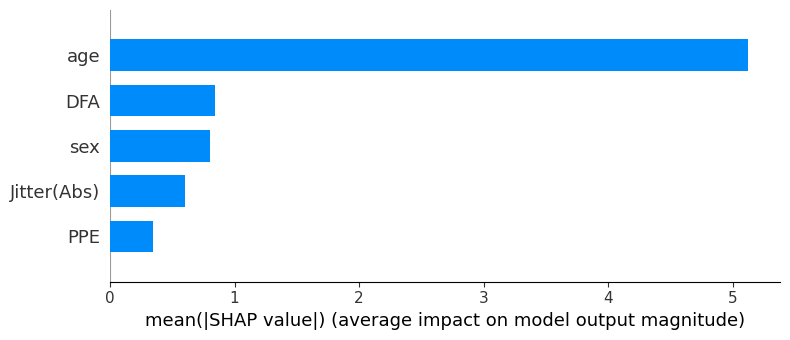

In [8]:
plot_factory = ShapPlotFeatures(shap_feature_selector,type_of_plot='bar_plot')
plot_factory.bar_plot()


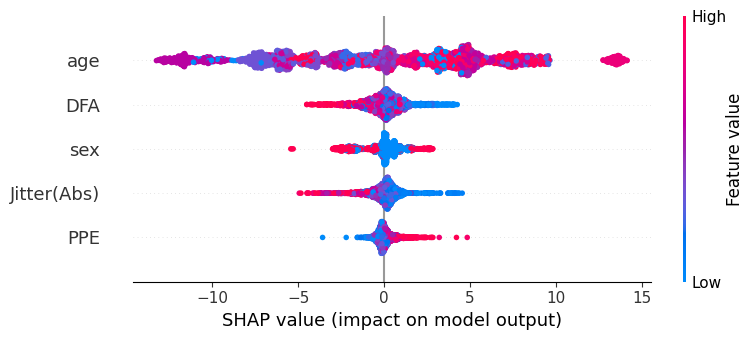

In [9]:
plot_factory.summary_plot()

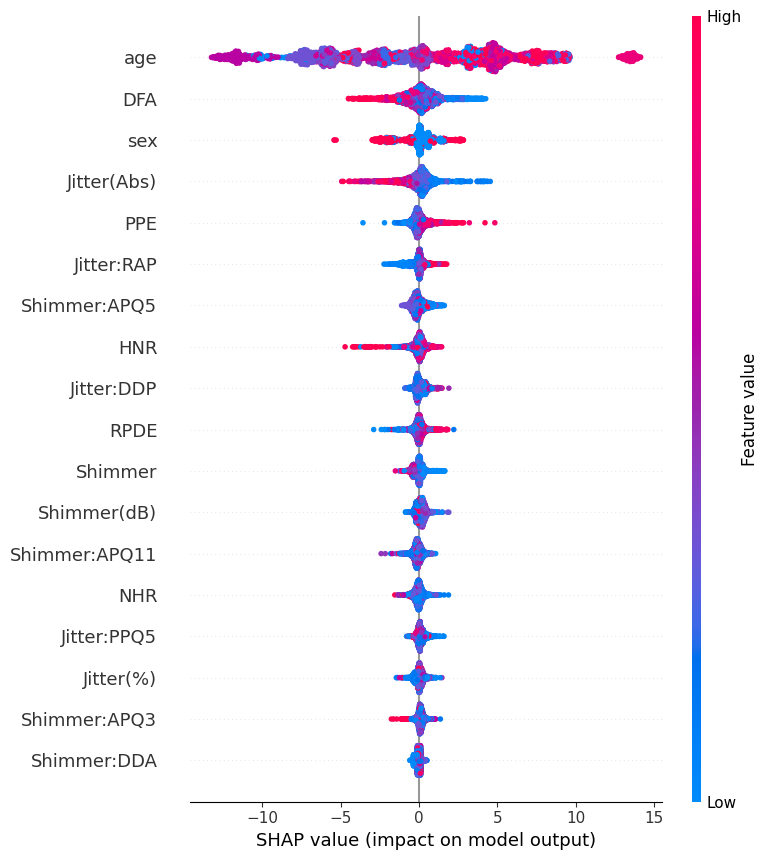

In [10]:
plot_factory.summary_plot_full()